# Stock Price Prediction using CNN-LSTM model

In [193]:
#importing libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import pandas_datareader as dr
%matplotlib inline
import yfinance as yahooFinance
yahooFinance.pdr_override()

import os
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error


from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

from warnings import simplefilter

simplefilter(action='ignore', category = FutureWarning)

# Data Preprocessing & Analysis

In [93]:
#getting APPLE('AAPL') data from yahoo finance

data = dr.data.get_data_yahoo('AAPL', start = '2010-01-01', end = '2018-12-30')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410791,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800


In [94]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-21,39.215000,39.540001,37.407501,37.682499,36.370232,382978400
2018-12-24,37.037498,37.887501,36.647499,36.707500,35.429192,148676800
2018-12-26,37.075001,39.307499,36.680000,39.292500,37.924164,234330000
2018-12-27,38.959999,39.192501,37.517502,39.037498,37.678051,212468400
2018-12-28,39.375000,39.630001,38.637501,39.057499,37.697350,169165600


In [95]:
data = data.reset_index()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410791,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800


In [96]:
data.shape

(2263, 7)

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2263 non-null   datetime64[ns]
 1   Open       2263 non-null   float64       
 2   High       2263 non-null   float64       
 3   Low        2263 non-null   float64       
 4   Close      2263 non-null   float64       
 5   Adj Close  2263 non-null   float64       
 6   Volume     2263 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 123.9 KB


In [98]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2.263000e+03
mean,24.858793,25.076287,24.625687,24.855338,22.673154,3.205397e+08
std,11.691565,11.789160,11.595720,11.692901,11.590857,2.386935e+08
min,6.870357,7.000000,6.794643,6.858929,5.846673,4.590360e+07
25%,15.410714,15.547857,15.251429,15.371071,13.336578,1.376652e+08
50%,23.660000,23.887501,23.407499,23.620001,21.118347,2.536088e+08
75%,31.481250,31.712500,31.213750,31.458751,28.515196,4.307352e+08
max,57.695000,58.367500,57.445000,58.017502,55.802376,1.880998e+09


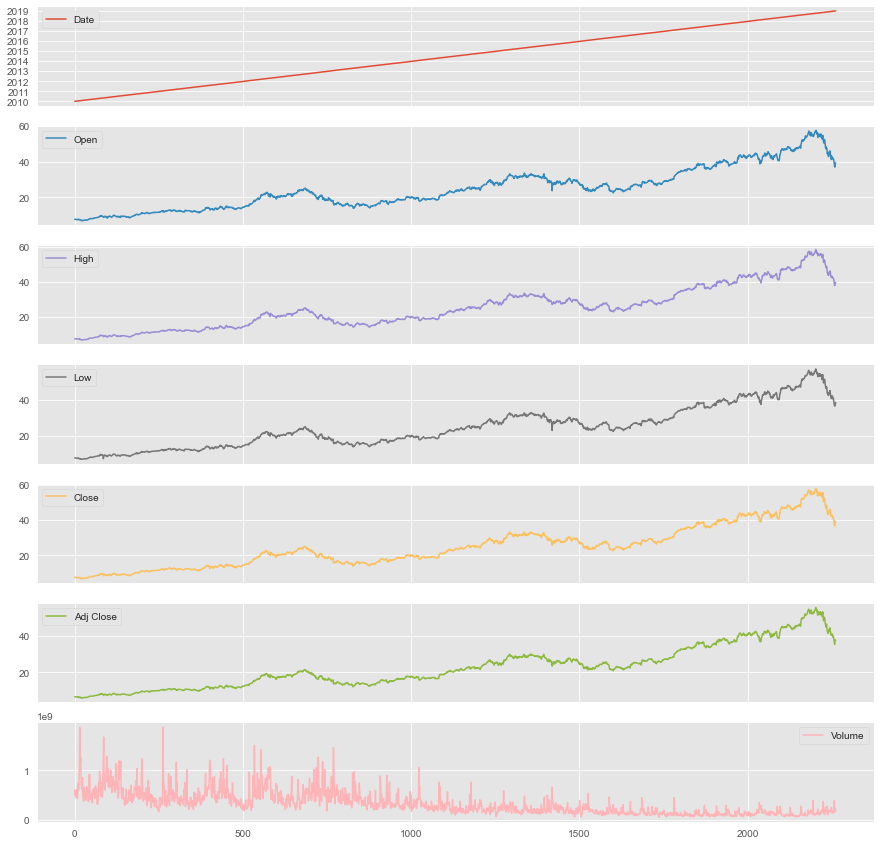

In [99]:
#Plotting the data

data.plot(legend=True,subplots=True, figsize = (15, 15))
plt.show()

Text(0, 0.5, 'Closing price')

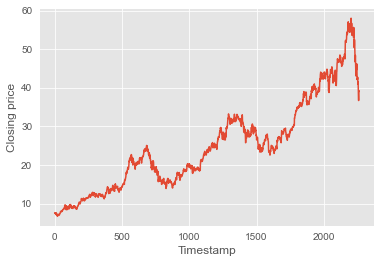

In [101]:
#Plotting the closing price of stocks

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")

In [102]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [103]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410791,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800


In [104]:
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [105]:
data.nunique()

Date         2263
Open         2166
High         2151
Low          2157
Close        2164
Adj Close    2227
Volume       2259
dtype: int64

In [106]:
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

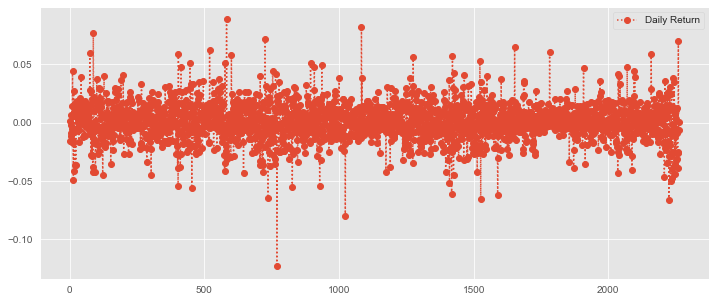

In [107]:
data['Daily Return'] = data['Close'].pct_change()
# plot the daily return percentage
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

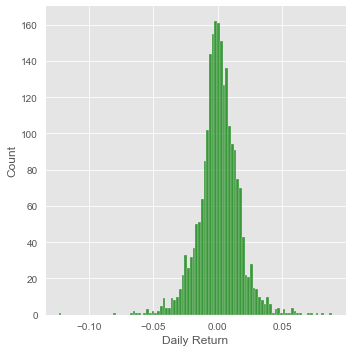

In [108]:
sns.displot(data['Daily Return'].dropna(),bins=100,color='green')
plt.show()

In [109]:
date=pd.DataFrame(data['Date'])
closing_df1 = pd.DataFrame(data['Close'])
close1  = closing_df1.rename(columns={"Close": "data_close"})
close2=pd.concat([date,close1],axis=1)
close2.head()

,Date,data_close
0,2010-01-04,7.643214
1,2010-01-05,7.656429
2,2010-01-06,7.534643
3,2010-01-07,7.520714
4,2010-01-08,7.570714


In [110]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA for 10 days,MA for 50 days,MA for 100 days,Daily Return
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600,24.861876,24.841298,24.713959,0.000853
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800,24.861876,24.841298,24.713959,0.001729
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000,24.861876,24.841298,24.713959,-0.015906
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410791,477131200,24.861876,24.841298,24.713959,-0.001849
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800,24.861876,24.841298,24.713959,0.006648


In [111]:
data.nunique()

Date               2263
Open               2166
High               2151
Low                2157
Close              2164
Adj Close          2227
Volume             2259
MA for 10 days     2247
MA for 50 days     2215
MA for 100 days    2165
Daily Return       2261
dtype: int64

In [112]:
data.sort_index(axis=1,ascending=True)

,Adj Close,Close,Daily Return,Date,High,Low,MA for 10 days,MA for 100 days,MA for 50 days,Open,Volume
0,6.515213,7.643214,0.000853,2010-01-04,7.660714,7.585000,24.861876,24.713959,24.841298,7.622500,493729600
1,6.526476,7.656429,0.001729,2010-01-05,7.699643,7.616071,24.861876,24.713959,24.841298,7.664286,601904800
2,6.422665,7.534643,-0.015906,2010-01-06,7.686786,7.526786,24.861876,24.713959,24.841298,7.656429,552160000
3,6.410791,7.520714,-0.001849,2010-01-07,7.571429,7.466071,24.861876,24.713959,24.841298,7.562500,477131200
4,6.453411,7.570714,0.006648,2010-01-08,7.571429,7.466429,24.861876,24.713959,24.841298,7.510714,447610800
...,...,...,...,...,...,...,...,...,...,...,...
2258,36.370232,37.682499,-0.038896,2018-12-21,39.540001,37.407501,41.055500,51.421750,48.172250,39.215000,382978400
2259,35.429192,36.707500,-0.025874,2018-12-24,37.887501,36.647499,40.486250,51.285075,47.834150,37.037498,148676800
2260,37.924164,39.292500,0.070422,2018-12-26,39.307499,36.680000,40.199750,51.159525,47.509450,37.075001,234330000
2261,37.678051,39.037498,-0.006490,2018-12-27,39.192501,37.517502,39.876000,51.029925,47.203400,38.959999,212468400


Text(0, 0.5, 'Closing price')

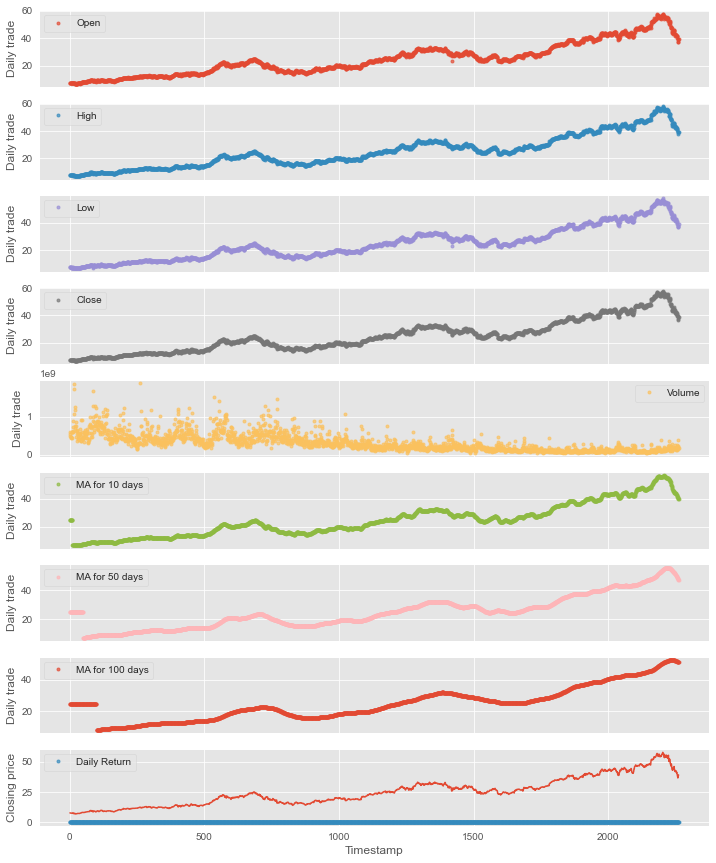

In [113]:
cols_plot = ['Open', 'High', 'Low','Close','Volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = data[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(12, 15), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")

In [114]:
df = data
print(df)

           Date       Open       High        Low      Close  Adj Close  \
0    2010-01-04   7.622500   7.660714   7.585000   7.643214   6.515213   
1    2010-01-05   7.664286   7.699643   7.616071   7.656429   6.526476   
2    2010-01-06   7.656429   7.686786   7.526786   7.534643   6.422665   
3    2010-01-07   7.562500   7.571429   7.466071   7.520714   6.410791   
4    2010-01-08   7.510714   7.571429   7.466429   7.570714   6.453411   
...         ...        ...        ...        ...        ...        ...   
2258 2018-12-21  39.215000  39.540001  37.407501  37.682499  36.370232   
2259 2018-12-24  37.037498  37.887501  36.647499  36.707500  35.429192   
2260 2018-12-26  37.075001  39.307499  36.680000  39.292500  37.924164   
2261 2018-12-27  38.959999  39.192501  37.517502  39.037498  37.678051   
2262 2018-12-28  39.375000  39.630001  38.637501  39.057499  37.697350   

         Volume  MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0     493729600       24.86187

In [115]:
data.isnull().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA for 10 days     0
MA for 50 days     0
MA for 100 days    0
Daily Return       0
dtype: int64

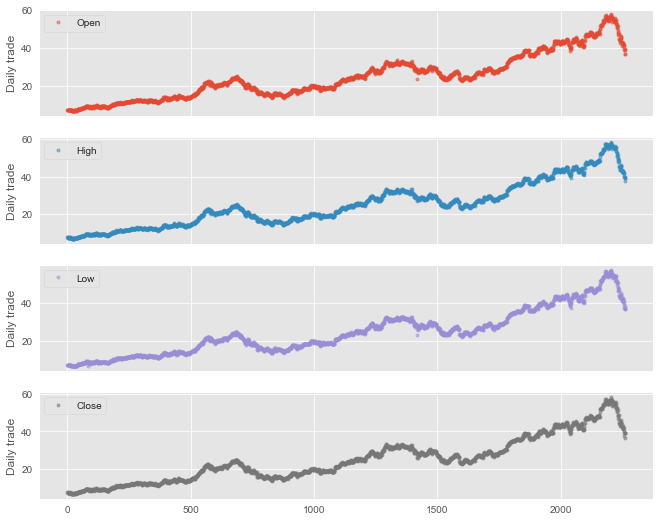

In [116]:
#Visualizing the data 

cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

Text(0, 0.5, 'Closing price')

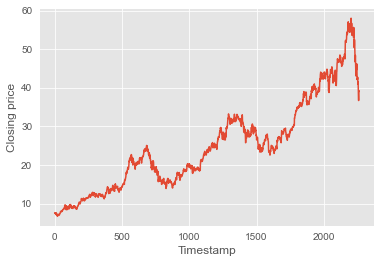

In [117]:
#Printing the data

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")


In [118]:
df = data
print(df)

           Date       Open       High        Low      Close  Adj Close  \
0    2010-01-04   7.622500   7.660714   7.585000   7.643214   6.515213   
1    2010-01-05   7.664286   7.699643   7.616071   7.656429   6.526476   
2    2010-01-06   7.656429   7.686786   7.526786   7.534643   6.422665   
3    2010-01-07   7.562500   7.571429   7.466071   7.520714   6.410791   
4    2010-01-08   7.510714   7.571429   7.466429   7.570714   6.453411   
...         ...        ...        ...        ...        ...        ...   
2258 2018-12-21  39.215000  39.540001  37.407501  37.682499  36.370232   
2259 2018-12-24  37.037498  37.887501  36.647499  36.707500  35.429192   
2260 2018-12-26  37.075001  39.307499  36.680000  39.292500  37.924164   
2261 2018-12-27  38.959999  39.192501  37.517502  39.037498  37.678051   
2262 2018-12-28  39.375000  39.630001  38.637501  39.057499  37.697350   

         Volume  MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0     493729600       24.86187

In [119]:
#Dropping null data

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,2263.0,2.485879e+01,1.169156e+01,6.870357e+00,1.541071e+01,2.366000e+01,3.148125e+01,5.769500e+01
High,2263.0,2.507629e+01,1.178916e+01,7.000000e+00,1.554786e+01,2.388750e+01,3.171250e+01,5.836750e+01
Low,2263.0,2.462569e+01,1.159572e+01,6.794643e+00,1.525143e+01,2.340750e+01,3.121375e+01,5.744500e+01
Close,2263.0,2.485534e+01,1.169290e+01,6.858929e+00,1.537107e+01,2.362000e+01,3.145875e+01,5.801750e+01
Adj Close,2263.0,2.267315e+01,1.159086e+01,5.846673e+00,1.333658e+01,2.111835e+01,2.851520e+01,5.580238e+01
Volume,2263.0,3.205397e+08,2.386935e+08,4.590360e+07,1.376652e+08,2.536088e+08,4.307352e+08,1.880998e+09
MA for 10 days,2263.0,2.486188e+01,1.163742e+01,6.976750e+00,1.551439e+01,2.377575e+01,3.144787e+01,5.656600e+01
MA for 50 days,2263.0,2.484130e+01,1.130432e+01,7.391336e+00,1.556880e+01,2.403430e+01,3.075070e+01,5.533000e+01
MA for 100 days,2263.0,2.471396e+01,1.070614e+01,8.091171e+00,1.630143e+01,2.471396e+01,3.011595e+01,5.247358e+01
Daily Return,2263.0,8.527143e-04,1.619747e-02,-1.235579e-01,-7.031432e-03,6.759663e-04,9.613061e-03,8.874128e-02


In [120]:
#The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train...
#Else it won't select necessary features and the model will fail

from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

1728
433


# Training the Model

In [122]:
#CNN and LSTM
#For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.
#After that, it's passed to Bi-LSTM layers


# For creating model and training

model = tf.keras.Sequential()

# Neural Network model

# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))


# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40
44/44 [==============================] - 12s 75ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0880 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0581
Epoch 2/40
44/44 [==============================] - 1s 28ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0552 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0505
Epoch 3/40
44/44 [==============================] - 1s 27ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0521 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0495
Epoch 4/40
44/44 [==============================] - 1s 27ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0466 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0421
Epoch 5/40
44/44 [==============================] - 1s 27ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0452 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0425
Epoch 6/40
44/44 [==============================] - 1s 26ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0419 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0419
Epoch 7/40
44/44 [===

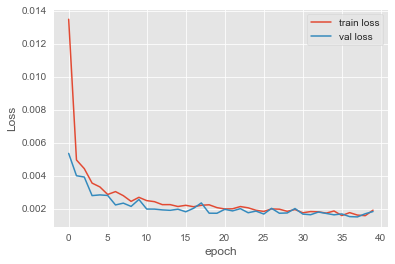

In [123]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

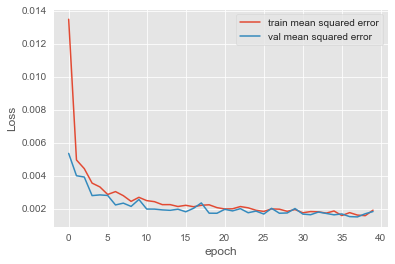

In [125]:
plt.plot(history.history['mse'], label='train mean squared error')
plt.plot(history.history['val_mse'], label='val mean squared error')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

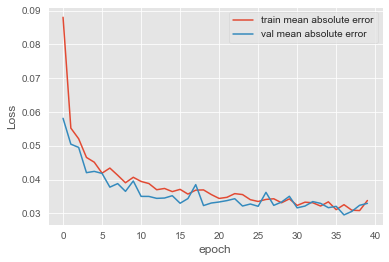

In [127]:
plt.plot(history.history['mae'], label='train mean absolute error')
plt.plot(history.history['val_mae'], label='val mean absolute error')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [129]:
from tensorflow.keras.utils import plot_model
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 98, 64)        256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 49, 64)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 47, 128)       24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 23, 128)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 21, 64)        2

In [130]:
model.evaluate(test_X, test_Y)

14/14 [==============================] - 0s 6ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0330


[0.0018250936409458518, 0.0018250936409458518, 0.03299111872911453]

In [132]:
# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.928169
R2 Score: 0.928169
Max Error: 0.141280


14/14 [==============================] - 0s 6ms/step


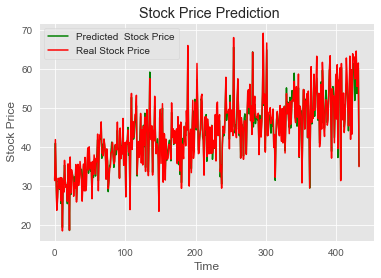

In [133]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Testing the Model

In [140]:
# First we need to save a model
#In this part, the model is saved and loaded back again. Then, it's made to train again but with different data to check it's loss and prediction

model.save("model.h5")

In [141]:
# Load model

new_model = tf.keras.models.load_model("./model.h5")

In [142]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 98, 64)        256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 49, 64)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 47, 128)       24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 23, 128)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 21, 64)        2

In [158]:
data2 = dr.data.get_data_yahoo('AAPL', start = '2019-01-01', end = '2022-12-31')
data2.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.105133,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.309582,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.774239,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.694611,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.375065,164101200


In [159]:
data2.reset_index(drop=True, inplace=True)
data2.fillna(data.mean(), inplace=True)
data2.head()




,Open,High,Low,Close,Adj Close,Volume
0,38.722500,39.712502,38.557499,39.480000,38.105133,148158800
1,35.994999,36.430000,35.500000,35.547501,34.309582,365248800
2,36.132500,37.137501,35.950001,37.064999,35.774239,234428400
3,37.174999,37.207500,36.474998,36.982498,35.694611,219111200
4,37.389999,37.955002,37.130001,37.687500,36.375065,164101200


In [160]:
df2 = data2
print(df2)

            Open        High         Low       Close   Adj Close     Volume
0      38.722500   39.712502   38.557499   39.480000   38.105133  148158800
1      35.994999   36.430000   35.500000   35.547501   34.309582  365248800
2      36.132500   37.137501   35.950001   37.064999   35.774239  234428400
3      37.174999   37.207500   36.474998   36.982498   35.694611  219111200
4      37.389999   37.955002   37.130001   37.687500   36.375065  164101200
...          ...         ...         ...         ...         ...        ...
1003  130.919998  132.419998  129.639999  131.860001  131.860001   63814900
1004  131.380005  131.410004  128.720001  130.029999  130.029999   69007800
1005  129.669998  131.029999  125.870003  126.040001  126.040001   85438400
1006  127.989998  130.479996  127.730003  129.610001  129.610001   75703700
1007  128.410004  129.949997  127.430000  129.929993  129.929993   76960600

[1008 rows x 6 columns]


In [161]:
X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    # for j in range(week):
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

724
182


In [162]:
model.evaluate(test_X, test_Y)

6/6 [==============================] - 0s 8ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0548


[0.004522680304944515, 0.004522680304944515, 0.05478876829147339]

6/6 [==============================] - 0s 7ms/step


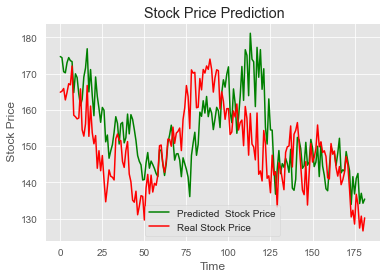

In [163]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data2.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Exploratory Data Analysis for visualizing the collecting data

In [198]:
dataX =  dr.data.get_data_yahoo('AAPL', start = '2020-01-01', end = '2021-11-29')
dataY =  dr.data.get_data_yahoo('AAPL', start = '2018-01-01', end = '2020-01-01')
dataX.info()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 481 entries, 2020-01-02 to 2021-11-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       481 non-null    float64
 1   High       481 non-null    float64
 2   Low        481 non-null    float64
 3   Close      481 non-null    float64
 4   Adj Close  481 non-null    float64
 5   Volume     481 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.3 KB


In [199]:
dataX.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.561539,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.846375,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.426826,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.081482,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.257111,132079200


In [200]:
dataX.describe()

,Open,High,Low,Close,Adj Close,Volume
count,481.000000,481.000000,481.000000,481.000000,481.000000,4.810000e+02
mean,115.324595,116.707812,113.973259,115.402141,114.076656,1.246746e+08
std,27.488048,27.524266,27.325636,27.424716,27.477100,6.416646e+07
min,57.020000,57.125000,53.152500,56.092499,55.082981,4.100000e+07
25%,90.019997,91.250000,88.254997,90.014999,88.634254,8.086110e+07
50%,122.540001,123.870003,120.540001,122.150002,120.799873,1.081818e+08
75%,135.759995,136.740005,133.690002,134.990005,133.606827,1.481995e+08
max,161.679993,165.699997,161.000000,161.940002,161.005569,4.265100e+08


In [201]:
dataY.describe()

,Open,High,Low,Close,Adj Close,Volume
count,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02
mean,49.627227,50.107908,49.186635,49.668444,48.012622,1.240777e+08
std,7.451311,7.477226,7.448893,7.500195,7.554141,5.277873e+07
min,35.994999,36.430000,35.500000,35.547501,34.309586,4.544800e+07
25%,43.865000,44.332500,43.588751,43.878750,42.158089,8.701420e+07
50%,47.974998,48.549999,47.762501,48.145000,46.355839,1.110428e+08
75%,54.039999,54.740000,53.375000,53.868752,51.993574,1.460904e+08
max,72.779999,73.492500,72.379997,73.412498,71.920578,3.849868e+08


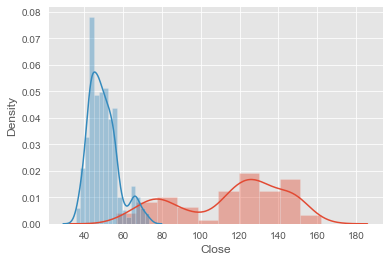

In [202]:

sns_plot = sns.distplot(dataX['Close'])
sns_plot2 = sns.distplot(dataY['Close'])

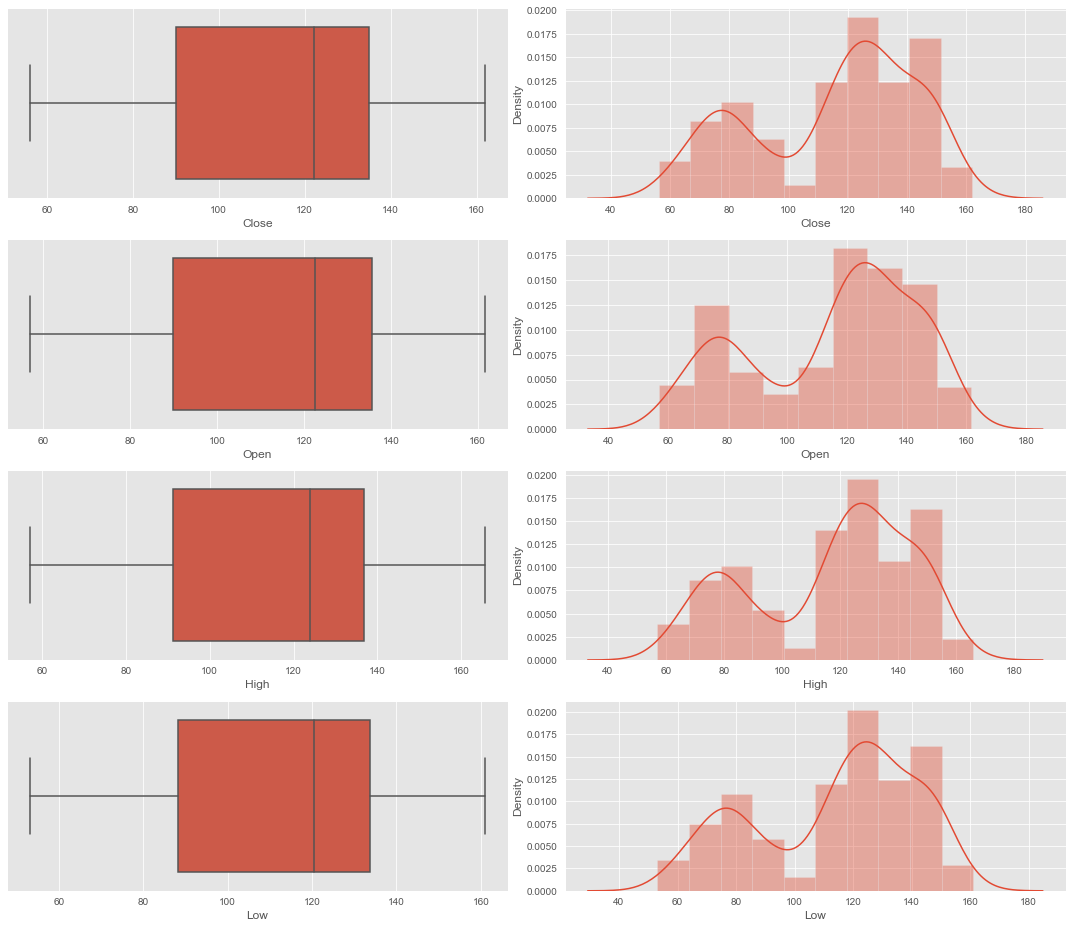

In [203]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["Close"], ax = ax[0,0])
sns.distplot(dataX['Close'], ax = ax[0,1])
sns.boxplot(x= dataX["Open"], ax = ax[1,0])
sns.distplot(dataX['Open'], ax = ax[1,1])
sns.boxplot(x= dataX["High"], ax = ax[2,0])
sns.distplot(dataX['High'], ax = ax[2,1])
sns.boxplot(x= dataX["Low"], ax = ax[3,0])
sns.distplot(dataX['Low'], ax = ax[3,1])
plt.tight_layout()

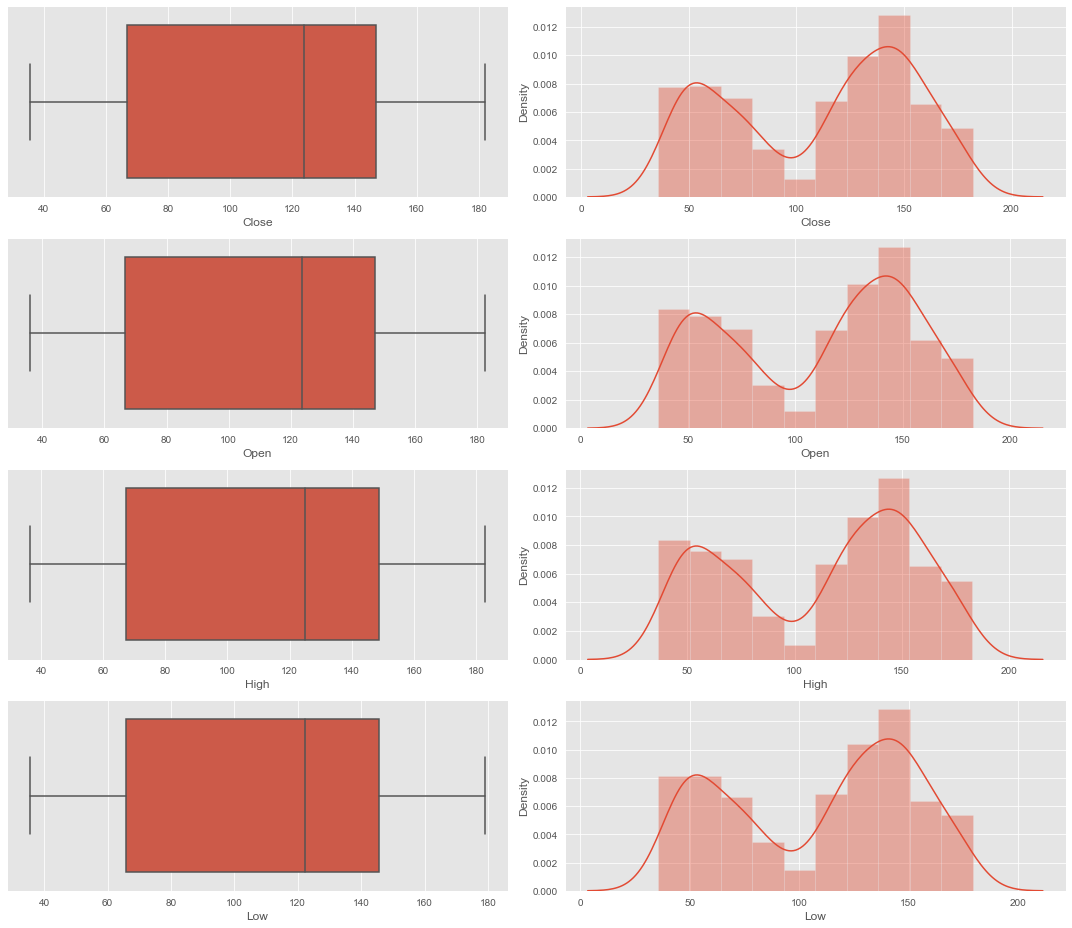

In [186]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["Close"], ax = ax[0,0])
sns.distplot(dataY['Close'], ax = ax[0,1])
sns.boxplot(x= dataY["Open"], ax = ax[1,0])
sns.distplot(dataY['Open'], ax = ax[1,1])
sns.boxplot(x= dataY["High"], ax = ax[2,0])
sns.distplot(dataY['High'], ax = ax[2,1])
sns.boxplot(x= dataY["Low"], ax = ax[3,0])
sns.distplot(dataY['Low'], ax = ax[3,1])
plt.tight_layout()

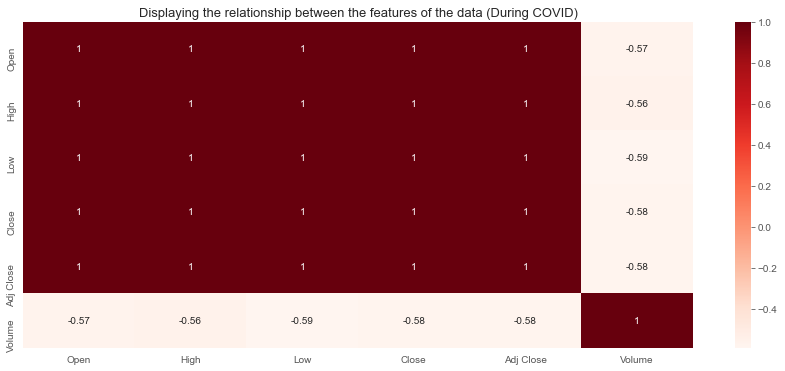

In [205]:
plt.figure(figsize=(15,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

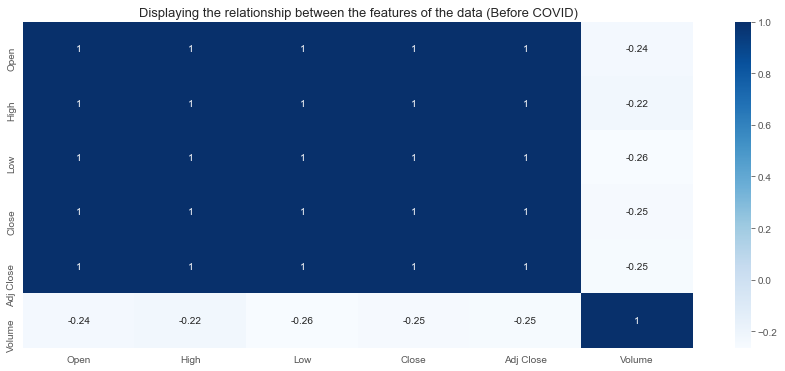

In [206]:
plt.figure(figsize=(15,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()